- Feed-forward neural network development

Aim of the colab sheet is to develop a feed-forward neural network with tensorflow-keras framework in order to train it and classify new unseen proteins to be antigenic or non antigenic.

In [ ]:
# Author: Francesco Patanè

%%capture
!pip install Biopython
# clone iFeature package for descriptors calculation from proteic seqs
!git clone https://github.com/Superzchen/iFeature

# import libraries
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO
from random import sample
import random

# set a seed for reproducibility
np.random.seed(42)

In [ ]:
# install wandb only if you want doing final hyperparameters tuning
!pip install wandb

In [ ]:
import wandb
wandb.init(project="uncategorized")

upload .fasta files obtained from preprocessing module. before of this, remember to clusterize proteins with cd-hit (preventing homology based biases, we recommend 25-30% of max threshold similarity). Obtained files are called 'pos30.fasta' and 'neg30.fasta'.

In [ ]:
file = open("neg30.fasta")
n = 0
for line in file:
    if line.startswith(">"):
        n += 1
file.close()
print('number of negative sequences:', n)

no sequences: 242


In [ ]:
file = open("pos30.fasta")
n = 0
for line in file:
    if line.startswith(">"):
        n += 1
file.close()
print('number of positive sequences:', n)

no sequences: 416


Important: remember to balance classes. in this case we have 416 positive seqs and 242 negative ones. So we have to do a randomized undersampling of the majority class (positive).

In [ ]:
with open("pos30.fasta") as f:
    seqs = SeqIO.parse(f,"fasta")
    x = (sample(list(seqs), 242))

f = open("pos30.1","w")
SeqIO.write(x, f, "fasta")

242

- Descriptors calculation with iFeature

In [ ]:
# put the right path
!python iFeature/iFeature.py --file ./pos30.fasta --type AAC --out aac_pos.out    # mono aminoacids composition
!python iFeature/iFeature.py --file ./pos30.fasta --type DPC --out dpc_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./pos30.fasta --type CTDC --out ctdc_pos.out  # composition
!python iFeature/iFeature.py --file ./pos30.fasta --type CTDT --out ctdt_pos.out  # transition
!python iFeature/iFeature.py --file ./pos30.fasta --type CTDD --out ctdd_pos.out  # distribution

print("positive: DONE!")

!python iFeature/iFeature.py --file ./neg30.fasta --type AAC --out aac_neg.out    # mono aminoacids composition
!python iFeature/iFeature.py --file ./neg30.fasta --type DPC --out dpc_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./neg30.fasta --type CTDC --out ctdc_neg.out  # composition
!python iFeature/iFeature.py --file ./neg30.fasta --type CTDT --out ctdt_neg.out  # transition
!python iFeature/iFeature.py --file ./neg30.fasta --type CTDD --out ctdd_neg.out  # distribution

print("negative: DONE!")


Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
positive: DONE!
Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
negative: DONE!


In [ ]:
def data2vec(fasta_path, positive=True):
    """this module concatenates descriptors"""
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'positive.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'negative.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')    
                
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    
                    return datasets
                    
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [ ]:
# put the right path
pos_datasets = data2vec("./", positive=True)
neg_datasets = data2vec("./", positive=False)

In [ ]:
# assign labels (positive-->1, negative-->0)
y_pos = np.ones(pos_datasets[0].shape[0])
y_neg = np.zeros(neg_datasets[0].shape[0])

In [ ]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of antigens and the number of not antigens
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Antigens:', n_pos)
print('NON Antigens:', n_neg)

Antigens: 241
NON Antigens: 242


In [ ]:
# feature vectors dimensions
columns = 0
num_descriptors = []
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim
    num_descriptors.append(i+1)
num_descriptors = (len(num_descriptors))

1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195


In [ ]:
# data matrix to process
X = np.zeros((rows, columns))
print('Data matrix dimension:', X.shape)

for i in range(n_pos):
    X[i] = np.concatenate([pos_datasets[j][i] for j in range(num_descriptors)])
for i in range(n_neg):
    X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(num_descriptors)])

Data matrix dimension: (483, 693)


In [ ]:
# random permutation
y = np.concatenate((y_pos, y_neg), axis=0)
c = np.random.permutation(np.arange(y.shape[0]))
y = y[c]
X = X[c]

train/test split

In [ ]:
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]

val_size = int(X.shape[0] * 0.1)
X_val = X[-val_size:]
y_val = y[-val_size:]

test_size = int(X.shape[0] * 0.1)
X_test = X[-test_size:]
y_test = y[-test_size:]


In [ ]:
print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test adhesins and not-adhesins:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (386, 693) (386,)
Validation data shape: (48, 693) (48,)
Test adhesins and not-adhesins: 24 24


Neural networks based on numeric inputs require standardize dat. This allows the network not to focus on scaling the data and to do a faster training.

In [ ]:
# standardize data
# remember that test and validation data have to be standardized with training mean and std dev
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

# print some column vectors to check
print('Before standardization:')
print('mean of the first column:', np.mean(X_train[:,0]))
print('mean of the second column:', np.mean(X_train[:,1]))
print('mean of the 451-th column:', np.mean(X_train[:,450]))

stdX = np.zeros(X_train.shape)
stdX_val = np.zeros(X_val.shape)
stdX_test = np.zeros(X_test.shape)

means = np.zeros(X_train.shape[1])
std_devs = np.zeros(X_train.shape[1])

for j in range(X_train.shape[1]):
    column = X_train[:,j]
    means[j] = np.mean(column)
    std_devs[j] = np.std(column)

    stdX[:,j] = (column - means[j]) / std_devs[j]
    stdX_val[:,j] = (X_val[:,j] - means[j]) / std_devs[j]
    stdX_test[:,j] = (X_test[:,j] - means[j]) / std_devs[j]

print('After standardization:')
print('mean of the first column:', np.mean(stdX[:,0]))
print('mean of the second column:', np.mean(stdX[:,1]))
print('mean of the 451-th column:', np.mean(stdX[:,450]))

np.save('mean', means)
np.save('std', std_devs)

Before standardization:
mean of the first column: 0.06880059145099482
mean of the second column: 0.017562684867835507
mean of the 451-th column: 0.12224697127003106
After standardization:
mean of the first column: 4.3718626876431036e-17
mean of the second column: -1.7027254678188928e-16
mean of the 451-th column: 1.7947646822955898e-16


To reduce the number of features (variables) considered and to prevent overfitting (dimensionality curse), a best practice consists of using dimensionality reduction methods like PCA (principal component analysis). 

In [ ]:
covariance_matrix = np.cov(stdX.T)

In [ ]:
# The covariance matrix is symmetric, and thus has real eigenvalues. You may see a small imaginary part in some eigenvalues due to numerical error. The imaginary parts can generally be ignored.
# source: https://stackoverflow.com/questions/10420648/complex-eigen-values-in-pca-calculation

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

In [ ]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[15.529486631457656, 6.512846431083304, 4.369193086942696, 3.865137973058635, 2.8612580823019473, 2.3864285141540766, 1.9179739475735795, 1.6303073057913293, 1.4747931245899386, 1.4246798310704483, 1.3685598830257906, 1.2574120784591107, 1.2294947696332068, 1.1458363901143978, 1.0554174053025156, 0.9445264757154271, 0.9362562831863892, 0.9218249646865103, 0.8874370252826447, 0.8581517440398277, 0.8491766155583462, 0.810939311164183, 0.7631386271653593, 0.7263056899037822, 0.7141884189076442, 0.6919673104004503, 0.6713649793850317, 0.658305847283537, 0.6325147377121078, 0.6283366179027527, 0.6190645886118354, 0.5885182136181534, 0.594098400259981, 0.5584470169690607, 0.5466045407895076, 0.5373904683073985, 0.5291867444832044, 0.5189922261810517, 0.5018870436353448, 0.49937879056485646, 0.49331745579863007, 0.4803041598845052, 0.47782038779048885, 0.4660376175974921, 0.4509901465835163, 0.4370554137363464, 0.4296121723923, 0.42539366049587096, 0.4200616993421692, 0.41915890669298134, 0.4

In [ ]:
cumulative_variance_explained = np.cumsum(variance_explained)

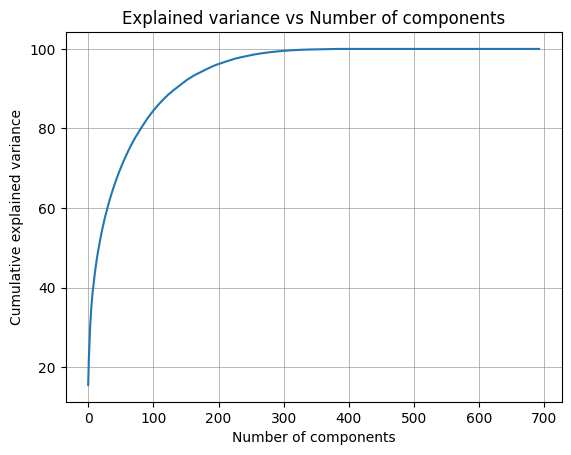

In [ ]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [ ]:
K = 300
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 300
Discarded components: 393


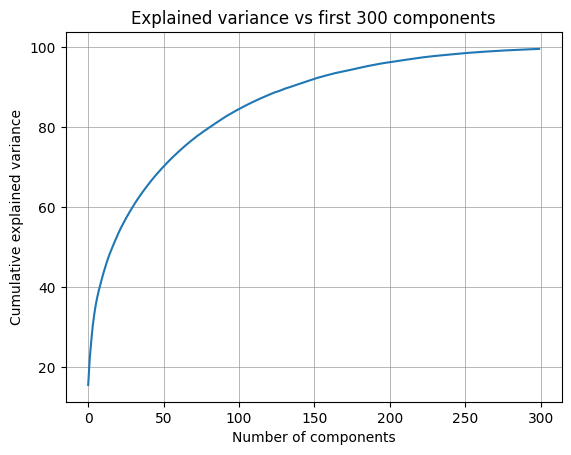

In [ ]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [ ]:
# Project using first K components

projection_matrix = np.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

np.save('projection_matrix', projection_matrix)

(693, 300)


In [ ]:
# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

- Feed-forward neural network development

In [ ]:
from tensorflow.keras import regularizers

class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=100, 
                                                activation='relu',
                                                kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                bias_regularizer=regularizers.L2(1e-3),
                                                activity_regularizer=regularizers.L2(1e-3))(input)
        norm = tensorflow.keras.layers.BatchNormalization()(dense)
        drop = tensorflow.keras.layers.Dropout(.8)(dense)
        dense = tensorflow.keras.layers.Dense(50, activation='relu')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [ ]:
nn = neural_network()

In [ ]:
nn.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=2000,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=100
        )]
)

Epoch 1/2000
7/7 [==============================] - 2s 47ms/step - loss: 3.6041 - accuracy: 0.5803 - val_loss: 3.0887 - val_accuracy: 0.6250
Epoch 2/2000
7/7 [==============================] - 0s 8ms/step - loss: 2.7499 - accuracy: 0.7435 - val_loss: 2.5670 - val_accuracy: 0.8125
Epoch 3/2000
7/7 [==============================] - 0s 8ms/step - loss: 2.3179 - accuracy: 0.8083 - val_loss: 2.1391 - val_accuracy: 0.8542
Epoch 4/2000
7/7 [==============================] - 0s 8ms/step - loss: 2.1747 - accuracy: 0.8083 - val_loss: 1.9157 - val_accuracy: 0.8750
Epoch 5/2000
7/7 [==============================] - 0s 8ms/step - loss: 2.0096 - accuracy: 0.8316 - val_loss: 1.8192 - val_accuracy: 0.8542
Epoch 6/2000
7/7 [==============================] - 0s 8ms/step - loss: 1.7840 - accuracy: 0.8705 - val_loss: 1.7365 - val_accuracy: 0.8333
Epoch 7/2000
7/7 [==============================] - 0s 8ms/step - loss: 1.6600 - accuracy: 0.8860 - val_loss: 1.6167 - val_accuracy: 0.8333
Epoch 8/2000
7/7 [=

In [ ]:
test_loss, test_acc = nn.model.evaluate(X_test, y_test)
#wandb.log({'test_accuracy': test_acc})


2/2 [==============================] - 0s 10ms/step - loss: 0.7037 - accuracy: 0.9167


In [ ]:
nn.model.save('antigen.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf

y_pred = nn.model.predict(X_test)

predicted_classes = np.round(y_pred)
true_classes = y_test
cm = confusion_matrix(true_classes, predicted_classes)

2/2 [==============================] - 0s 5ms/step


In [ ]:
print(cm)

[[23  1]
 [ 3 21]]


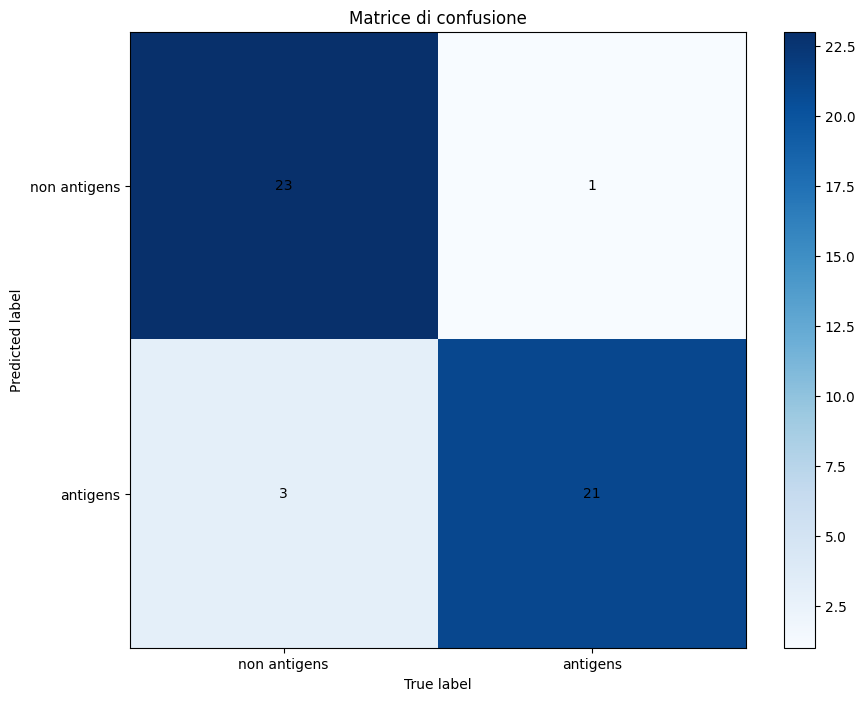

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# definisci le etichette dei labels
labels = ['non antigens', 'antigens']

# calcola la matrice di confusione
cm = confusion_matrix(true_classes, predicted_classes)

# visualizza la matrice di confusione
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       xlabel='True label',
       ylabel='Predicted label')

# aggiungi i valori della matrice di confusione all'interno dei quadrati
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

# aggiungi il titolo alla figura
ax.set_title('Matrice di confusione')
fig.set_size_inches(10, 8)
# mostra la figura
plt.show()


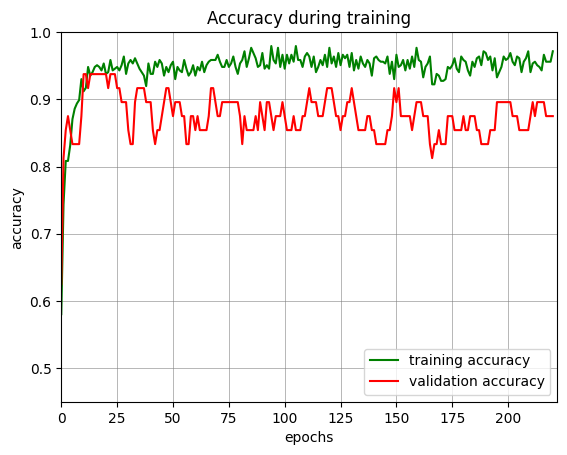

In [ ]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

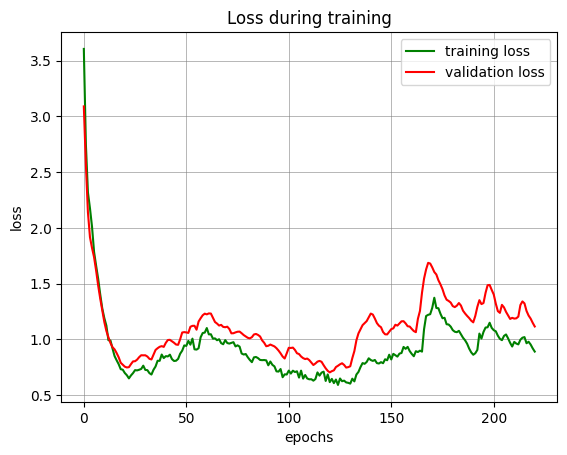

In [ ]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training loss', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss.png')